In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

# Define model and create sample trajectory

In [3]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1/7
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter 
gE    = 1/5
gA    = 1/3

tS    = 0.0            # rate S  -> Q
tE    = 0.01           # rate E  -> Q
tA    = 0.01           # rate A  -> Q
tIa   = 0.01           # rate Ia -> Q
tIs   = 1./5           # rate Is -> Q, five days for symptomatic people to be tested and quarantined 



# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
E0  = np.array([100, 100])
A0  = np.array([10, 10])
Ia0 = np.array([10, 10])     
Is0 = np.array([10, 10])     
Q0  = np.array([0, 0])
R0  = np.array([0, 0])     
S0  = Ni-(E0+A0+Ia0+Is0+R0+Q0)    


Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta,
              'gE':gE,'gA':gA,
              'gIa':gIa, 'gIs':gIs, 'fsa':fsa,
             'tS':tS,'tE':tE,'tA':tA,'tIa':tIa,'tIs':tIs, 
             'gAA': gA, 'gAS': gA} # legacy code 

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SEAIRQ(parameters, M, Ni)
data = sto_model.simulate(S0, E0, A0, Ia0, Is0, Q0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('SEAIRQ_traj.npy', data_array)

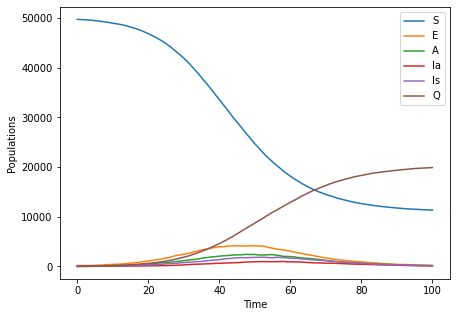

In [4]:
# plot the stochastic solution 
fig,ax = plt.subplots(1,1,figsize=(7,5))
ax.plot(np.sum (data_array[:, 0*M:1*M],axis=-1), label='S')
ax.plot(np.sum (data_array[:, 1*M:2*M],axis=-1), label='E')
ax.plot(np.sum (data_array[:, 2*M:3*M],axis=-1), label='A')
ax.plot(np.sum (data_array[:, 3*M:4*M],axis=-1), label='Ia')
ax.plot(np.sum (data_array[:, 4*M:5*M],axis=-1), label='Is')
ax.plot(np.sum (data_array[:, 5*M:6*M],axis=-1), label='Q')
ax.set_xlabel('Time')
ax.set_ylabel('Populations')
ax.legend()
plt.show(fig)
plt.close(fig)

# Infer parameters based on part of the trajectory

In [5]:
# load the data and rescale to intensive variables 
Tf_inference = 30 
Nf_inference = Tf_inference + 1 

x = np.load('SEAIRQ_traj.npy').astype('float')
x = x[:Nf_inference]/N
steps = 101 # number internal integration steps taken

# initialise the estimator 
estimator = pyross.inference.SEAIRQ(parameters, M, fi, int(N), steps)

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
logp = estimator.obtain_minus_log_p(parameters, x, Tf_inference, Nf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-2759.0183131573062
0.5043869018554688


In [6]:
eps = 1e-4 

alpha_g = 0.3         
alpha_std = 0.1
alpha_b = (eps, 0.5)

beta_g  = 0.05        
beta_std = 0.1
beta_b = (eps, 1)

gIa_g   = 0.13
gIa_std = 0.05 
gIa_b = (eps, 0.5)

gIs_g   = 0.13
gIs_std = 0.05 
gIs_b = (eps, 0.5) 

gE_g    = 0.25
gE_std = 0.1
gE_b = (eps, 0.5)

gA_g    = 0.3 
gA_std = 0.1
gA_b = (eps, 0.5) 
   

# optimisation parameters 
ftol = 1e-4 # the relative tol in (-logp)   
bounds = np.array([alpha_b, beta_b, gIa_b, gIs_b, gE_b, gA_b])
                   
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, gE_g, gA_g]) 
                   
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std, gE_std, gA_std]) 
            
start_time = time.time()
params = estimator.inference(guess, stds, x, Tf_inference, Nf_inference, 
                                    contactMatrix, bounds=bounds, 
                                    global_max_iter=20, global_ftol_factor=1e3, 
                                    verbose=True, ftol=ftol) 
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 6 (seed=943252, Thu May  7 21:47:05 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -3.659626430077716e+01 1.0e+00 8.62e-01  4e-02  9e-02 0:05.0
    2     32 -2.269877433639504e+03 1.2e+00 7.63e-01  4e-02  7e-02 0:09.2
    3     48 -2.471829199856244e+03 1.3e+00 7.89e-01  4e-02  7e-02 0:12.3
    4     64 -8.497069372121304e+02 1.6e+00 7.81e-01  4e-02  8e-02 0:15.4
    6     96 -2.069709746903199e+03 2.1e+00 8.74e-01  4e-02  9e-02 0:21.7
    8    128 -1.498225661201183e+03 2.6e+00 1.04e+00  5e-02  1e-01 0:30.3
   10    160 -2.367704762852077e+03 2.7e+00 1.37e+00  7e-02  2e-01 0:37.7
   12    192 -1.781555339266896e+03 3.0e+00 1.29e+00  6e-02  1e-01 0:45.0
   15    240 -2.563416714917999e+03 3.0e+00 9.01e-01  4e-02  8e-02 0:55.3
   18    288 -2.285888874229619e+03 3.6e+00 8.00e-01  3e-02  8e-02 1:05.3
Optimal value (global minimisation):  -2563.416714917999
Starting

In [7]:
hessian = estimator.hessian(params,guess, stds,x,Tf_inference,Nf_inference,contactMatrix)
cov = np.linalg.inv(hessian)
#cov

# Compare forecast based on inferred parameters to full trajectory

In [8]:
parameters = {'alpha':params[0], 'beta':params[1],
              'gIa':params[2], 'gIs':params[3],
              'gE':params[4],'gA':params[5],
               'fsa':fsa,
             'tE':tE,'tA':tA,'tIa':tIa,'tIs':tIs,
             'cov':cov
                }

# Initialise pyross forecast module
model_forecast = pyross.forecast.SEAIRQ(parameters, M, Ni)

In [9]:
# Initial condition for forecast is last configuration from inference-trajectory
S0_forecast = x[-1,:M]*N
E0_forecast = x[-1,M:2*M]*N
A0_forecast = x[-1,2*M:3*M]*N
Ia0_forecast = x[-1,3*M:4*M]*N
Is0_forecast = x[-1,4*M:5*M]*N
Q0_forecast = x[-1,5*M:6*M]*N


# Number of simulations over which we average
Ns = 100 

Tf_forecast = Tf - Tf_inference
Nf_forecast = Tf_forecast+1


result_forecast = model_forecast.simulate(S0_forecast, E0_forecast, A0_forecast,Ia0_forecast,
                                           Is0_forecast, Q0_forecast,
                                          contactMatrix, Tf_forecast, Nf_forecast,
                                      verbose=True,
                                          method='deterministic',
                                     Ns=Ns) 

trajectories_forecast = result_forecast['X']
t_forecast = result_forecast['t'] + Tf_inference

Finished. Time needed for evaluation: 00:00:00


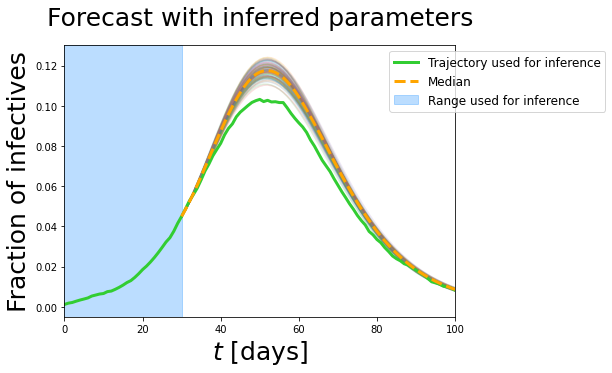

In [10]:
# Plot sum of A, Ia, Is populations

fontsize=25
#

ylabel=r'Fraction of infectives'
#

# Plot total number of symptomatic infectives
cur_trajectories_forecast = np.sum( trajectories_forecast[:,2*M:5*M,:] , axis = 1)
cur_mean_forecast = np.mean( cur_trajectories_forecast, axis=0)
percentile = 10
percentiles_lower = np.percentile(cur_trajectories_forecast,percentile,axis=0)
percentiles_upper = np.percentile(cur_trajectories_forecast,100-percentile,axis=0)
percentiles_median = np.percentile(cur_trajectories_forecast,50,axis=0)


cur_trajectory_underlying = np.sum( data_array[:,2*M:5*M] ,axis=1 )

#
# Plot trajectories
#
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.axvspan(0, Tf_inference, 
           label='Range used for inference',
           alpha=0.3, color='dodgerblue')
ax.set_title(r'Forecast with inferred parameters',
             y=1.05,
            fontsize=fontsize)
for i,e in enumerate(cur_trajectories_forecast):
    ax.plot(t_forecast,e/N,
            alpha=0.15,
           )
ax.plot(cur_trajectory_underlying/N,
        lw=3,
        color='limegreen',
       label='Trajectory used for inference')

ax.plot(t_forecast,percentiles_median/N,
                alpha=1,ls='--',
        color='orange',label='Median',
       lw=3)
''' # remove comments to plot percentiles
ax.plot(t_forecast,percentiles_lower/N,
                alpha=1,
        lw=2,
        label='Percentiles',
        ls='dotted',
        color='red',
       )
ax.plot(t_forecast,percentiles_upper/N,
                alpha=1,
        lw=2,
        color='red',
        ls='dotted',
       )
''';

ax.set_xlim(0,np.max(t_forecast))
ax.set_ylabel(ylabel,fontsize=fontsize)
ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
ax.legend(loc='upper right',bbox_to_anchor=(1.4,1),
          fontsize=12)
plt.show(fig)
#fig.savefig('inference_and_forecasting_SEAIRQ.png',bbox_inches='tight',dpi=100)
plt.close(fig)